# Multiclass Classification of Fatal Car Crashes
Authors:  Ned Kost, Ulises Gomez
Date:  August 25th, 2023

## Goal
Predict the contributing factor for a fatal car crash.  The contributing factor will fall into 3 categories: 
- drunk_driver_involved
- speeding_driver_involved
- other

## TODO
- Load Data into dataframe and clean it
- Identify features to use for the classifier model
- Find a classifier that will do multiclass and probabilty as output.  Preferrably with explainability
- Dockerize the output

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from pathlib import Path


In [112]:
warnings.filterwarnings("ignore")

## Load and Clean Data

In [113]:
train_directory = Path("../data/fars_train.csv")
test_directory = Path("../data/fars_test.csv")

In [114]:
#Load data from Dataframe
df = pd.read_csv(train_directory, quoting=1, delimiter=',')
df.head()


,u_id,fatals,a_ct,a_ped_f,a_pedal_f,a_roll,a_hr,a_polpur,month,day,...,owner,deaths,numoccs,impact1,deformed,ve_forms,ve_total,weather,lgt_cond,driver_factor
0,32083,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,10,2,...,Driver (in this crash) Was Registered Owner,1,1.0,Clockpoint 12,Disabling damage,1,1,Clear,Dark - not lighted,other
1,55073,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,6,21,...,Driver (in this crash) Not Registered Owner (o...,1,1.0,Clockpoint 1,Disabling damage,1,1,Clear,Daylight,speeding_driver_involved
2,7458,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,7,14,...,Driver (in this crash) Was Registered Owner,0,1.0,Clockpoint 12,NaN,1,1,Clear,Daylight,other
3,5685,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,9,15,...,Driver (in this crash) Not Registered Owner (o...,0,1.0,Clockpoint 12,Functional damage,1,1,Clear,Dark - not lighted,other
4,9245,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,9,28,...,Driver (in this crash) Was Registered Owner,1,1.0,Clockpoint 9,Disabling damage,1,1,Clear,Dark - not lighted,drunk_driver_involved


In [115]:
def binary_cat(row_value, zero_value):
    return 0 if row_value == zero_value else 1

In [116]:
#Clean up Categorical Data
features = ['fatals', 'permvit', 'age', 'deaths', 'month', 'pernotmvit', 've_total']


cleaned_df = df[features]
#cleaned_df['numoccs'] = cleaned_df['numoccs'].fillna(0.0)

#Create columns for Binary Features
cleaned_df['is_ped_fatality'] = df['a_ped_f'].apply(lambda x: binary_cat(x, 'Other Crash'))
cleaned_df['is_weekend'] = df['a_dow_type'].apply(lambda x: binary_cat(x, 'Weekday'))
cleaned_df['is_night'] = df['a_tod_type'].apply(lambda x: binary_cat(x, 'Daytime'))
cleaned_df['is_urban'] = df['a_ru'].apply(lambda x: binary_cat(x, 'Rural'))
cleaned_df['is_inter'] = df['a_inter'].apply(lambda x: binary_cat(x, 'Non-Interstate'))
cleaned_df['is_intsec'] = df['a_intsec'].apply(lambda x: binary_cat(x, 'Non-Intersection'))
cleaned_df['on_roadway'] = df['a_relrd'].apply(lambda x: 1 if x.startswith('On') else 0)
cleaned_df['off_roadway'] = df['a_relrd'].apply(lambda x: 1 if x.startswith('Off') else 0)
cleaned_df['is_junc'] = df['a_junc'].apply(lambda x: 1 if str(x).startswith('Junct') else 0)
cleaned_df['not_junc'] = df['a_junc'].apply(lambda x: 1 if str(x).startswith('Non') else 0)
#cleaned_df['is_bike_fatality'] = df['a_ped_f'].apply(lambda x: binary_cat(x, 'Other Crash'))
#cleaned_df['is_rollover'] = df['a_roll'].apply(lambda x: binary_cat(x, 'Other Crash'))   #hurt multi-nomial output
cleaned_df['is_hit_and_run'] = df['a_hr'].apply(lambda x: binary_cat(x, 'No - Hit and Run'))  #no impact to multi-nomial
cleaned_df['is_police_pursuit'] = df['a_polpur'].apply(lambda x: binary_cat(x, 'Other Crash'))  
cleaned_df['is_ped'] = df['a_ped'].apply(lambda x: binary_cat(x, 'no'))  

#Create columns for non-Ordinal Features
label_encoder = LabelEncoder()     #Create Label Encoder

#cleaned_df['owner_reg'] = label_encoder.fit_transform(df['owner'])
#cleaned_df['impact_loc'] = label_encoder.fit_transform(df['impact1'])
#cleaned_df['weather_cond'] = label_encoder.fit_transform(df['weather'])
#cleaned_df['light_cond'] = label_encoder.fit_transform(df['lgt_cond'])


cleaned_df['body_type'] = df['a_body']
cleaned_df['owner_reg'] = df['owner']
cleaned_df['impact_loc'] = df['impact1']
cleaned_df['weather_cond'] = df['weather']
cleaned_df['light_cond'] = df['lgt_cond']

for col in cleaned_df.dtypes[cleaned_df.dtypes == 'object'].index:
    for_dummy = cleaned_df.pop(col)
    cleaned_df = pd.concat([cleaned_df, pd.get_dummies(for_dummy, prefix=col)], axis=1)


#Create column for Ordinal Features (treating as non-ordinal FOR NOW)
cleaned_df['road_type'] = label_encoder.fit_transform(df['a_roadfc'])
cleaned_df['deform_type'] = label_encoder.fit_transform(df['deformed'])
#cleaned_df['state_occ'] = label_encoder.fit_transform(df['state'])  #very minor neg impat to multi-nomial

cleaned_df.head()

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - lighted,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type
0,1,1,62,1,10,0,1,0,0,1,...,False,True,False,False,False,False,False,False,4,0
1,1,1,40,1,6,0,1,0,0,0,...,False,False,False,False,True,False,False,False,3,0
2,1,1,26,0,7,1,1,0,0,1,...,False,False,False,False,True,False,False,False,2,4
3,1,1,64,0,9,1,1,0,0,1,...,False,True,False,False,False,False,False,False,5,1
4,1,1,45,1,9,0,1,0,0,1,...,False,True,False,False,False,False,False,False,2,0


# Build Train and Test dataset

In [117]:
#Create Datasets to use in Models
X = cleaned_df
y = df['driver_factor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=125)

In [118]:
X_train.head()

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - lighted,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type
2542,1,1,55,0,10,1,1,1,1,1,...,True,False,False,False,False,False,False,False,3,1
43289,1,1,63,1,1,0,1,0,0,0,...,False,True,False,False,False,False,False,False,2,0
14110,1,1,53,1,12,0,1,0,1,0,...,False,False,False,False,True,False,False,False,4,0
40780,1,1,86,1,12,0,1,0,0,0,...,False,False,False,False,True,False,False,False,2,0
17451,2,2,33,2,7,0,4,0,1,1,...,True,False,False,False,False,False,False,False,4,0


In [119]:
y_train.head()

2542                     other
43289    drunk_driver_involved
14110    drunk_driver_involved
40780                    other
17451    drunk_driver_involved
Name: driver_factor, dtype: object

## MultiNomial Naive Base Model

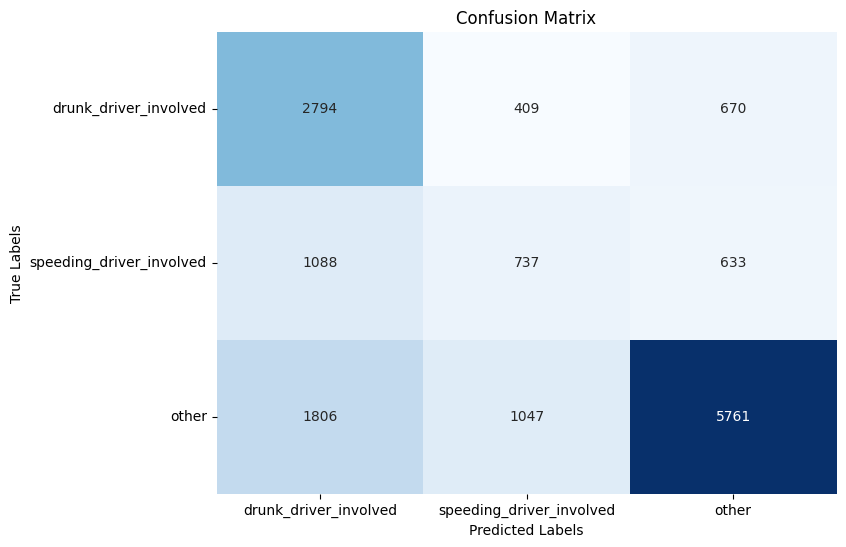

0.5454313175663948


In [120]:
#Multinomial Model
model = MultinomialNB()
model.fit(X,y)

predict = model.predict(X_test)

#Measure Output of MultiNomial Model
cat_lbl = ['drunk_driver_involved', 'speeding_driver_involved','other']
cm = confusion_matrix(y_test, predict, labels = cat_lbl )

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=cat_lbl,  yticklabels=cat_lbl)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f1_score(y_test, predict, average='macro', labels=cat_lbl))
#0.5503871319938812

## Gradient Boosting Model

In [121]:
cat_lbl = ['drunk_driver_involved', 'speeding_driver_involved','other']

X = cleaned_df
y = label_encoder.fit_transform(df['driver_factor'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=500)

    
gb_model = XGBClassifier(n_estimators=190, max_depth=6, learning_rate=0.13465232824084064, random_state=42)
gb_model.fit(X_train,y_train)
gb_predict = gb_model.predict(X_test)

gb_predict_decoded = label_encoder.inverse_transform(gb_predict)
y_test_decoded = label_encoder.inverse_transform(y_test)

print(f1_score(y_test_decoded, gb_predict_decoded, average='macro', labels=cat_lbl))

#0.5643295354621035
#0.5646008114078727
#0.5647829374800492

0.5647829374800492


In [122]:
X = cleaned_df
y_oVn = df['driver_factor'].apply(lambda x: 1 if x=='other' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y_oVn, test_size=.30, random_state=500)


gb_model = XGBClassifier(n_estimators=100, learning_rate=.25, random_state=42)
gb_model.fit(X_train,y_train)
gb_predict = gb_model.predict(X_test)
    
gb_predict_decoded = label_encoder.inverse_transform(gb_predict)
y_test_decoded = label_encoder.inverse_transform(y_test)
print(f1_score(y_test_decoded, gb_predict_decoded, average='macro', labels=cat_lbl))




0.5053637037133512


# MultiNomialNB

In [123]:
df["driver_factor"].unique()

array(['other', 'speeding_driver_involved', 'drunk_driver_involved'],
      dtype=object)

In [124]:
#Take entire TEST Dataset and perform MultiNomialNB based on if it is OTHER or NOT-OTHER
X = cleaned_df
y_oVn = df['driver_factor'].apply(lambda x: 'Other' if x=='other' else 'Not Other')

In [157]:
X.shape

(45286, 81)

In [125]:
X.head()

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - lighted,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type
0,1,1,62,1,10,0,1,0,0,1,...,False,True,False,False,False,False,False,False,4,0
1,1,1,40,1,6,0,1,0,0,0,...,False,False,False,False,True,False,False,False,3,0
2,1,1,26,0,7,1,1,0,0,1,...,False,False,False,False,True,False,False,False,2,4
3,1,1,64,0,9,1,1,0,0,1,...,False,True,False,False,False,False,False,False,5,1
4,1,1,45,1,9,0,1,0,0,1,...,False,True,False,False,False,False,False,False,2,0


In [126]:
y_oVn.unique()

array(['Other', 'Not Other'], dtype=object)

In [127]:
y_oVn.head()

0        Other
1    Not Other
2        Other
3        Other
4    Not Other
Name: driver_factor, dtype: object

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y_oVn, test_size=.30, random_state=500)

In [129]:
X_train.head()

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - lighted,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type
17107,1,1,28,1,8,0,1,0,1,1,...,False,True,False,False,False,False,False,False,2,0
23550,1,1,27,1,7,0,1,0,0,1,...,False,True,False,False,False,False,False,False,4,0
18250,1,1,44,0,8,1,1,1,0,0,...,False,False,False,False,True,False,False,False,5,2
42090,1,2,34,1,10,0,1,0,0,1,...,False,True,False,False,False,False,False,False,3,0
42215,1,1,22,1,5,0,1,0,0,0,...,False,False,False,False,True,False,False,False,4,0


In [130]:
y_train.head()

17107    Not Other
23550    Not Other
18250        Other
42090    Not Other
42215    Not Other
Name: driver_factor, dtype: object

In [131]:
#Multinomial Model
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [132]:
predict = model.predict(X_test)
print(predict)

['Not Other' 'Not Other' 'Other' ... 'Other' 'Other' 'Other']


f1 score: 0.7174201524593325


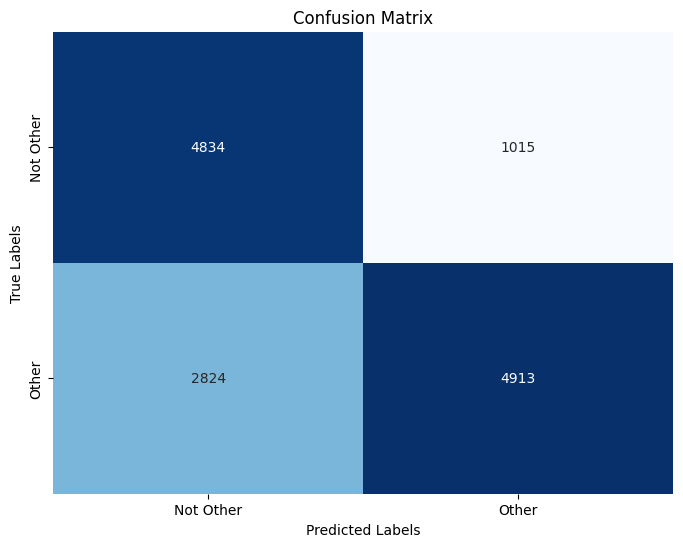

In [133]:
#Measure Output of MultiNomial Model
cat_lbl = ['Not Other', 'Other']
cm = confusion_matrix(y_test, predict, labels = cat_lbl )

print(f"f1 score: {f1_score(y_test, predict, average='macro', labels=cat_lbl)}")
#0.5503871319938812

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=cat_lbl,  yticklabels=cat_lbl)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [134]:
df['driver_factor']

0                           other
1        speeding_driver_involved
2                           other
3                           other
4           drunk_driver_involved
                   ...           
45281                       other
45282    speeding_driver_involved
45283                       other
45284                       other
45285       drunk_driver_involved
Name: driver_factor, Length: 45286, dtype: object

In [135]:
#Filter cleaned_df to only be Drunk Driver or Speeding (i.e. NOT OTHER)
X_not_other = cleaned_df[cleaned_df.index.isin(df[df['driver_factor'] != 'other'].index)]  #X data (i.e. feature) only contains durnk or speeding
df_filtered = df[df['driver_factor'] != 'other']  
y_dvs = df_filtered['driver_factor']     #y Data (i.e. Labels) only contains Drunk or Speeding

In [136]:
X_not_other.head()

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - lighted,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type
1,1,1,40,1,6,0,1,0,0,0,...,False,False,False,False,True,False,False,False,3,0
4,1,1,45,1,9,0,1,0,0,1,...,False,True,False,False,False,False,False,False,2,0
7,1,1,24,0,2,1,1,1,1,1,...,True,False,False,False,False,False,False,False,5,0
9,1,1,54,1,6,0,1,0,1,0,...,False,False,False,False,True,False,False,False,2,0
10,1,1,26,1,6,0,1,0,1,1,...,True,False,False,False,False,False,False,False,3,1


In [137]:
df_filtered.head()

,u_id,fatals,a_ct,a_ped_f,a_pedal_f,a_roll,a_hr,a_polpur,month,day,...,owner,deaths,numoccs,impact1,deformed,ve_forms,ve_total,weather,lgt_cond,driver_factor
1,55073,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,6,21,...,Driver (in this crash) Not Registered Owner (o...,1,1.0,Clockpoint 1,Disabling damage,1,1,Clear,Daylight,speeding_driver_involved
4,9245,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,9,28,...,Driver (in this crash) Was Registered Owner,1,1.0,Clockpoint 9,Disabling damage,1,1,Clear,Dark - not lighted,drunk_driver_involved
7,38215,1,Single-Vehicle Crash,Pedestrian Fatality Involved Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,2,4,...,Driver (in this crash) Was Registered Owner,0,1.0,Clockpoint 12,Disabling damage,1,1,Clear,Dark - lighted,speeding_driver_involved
9,21385,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,6,4,...,"Not Applicable, Vehicle Not Registered",1,1.0,Clockpoint 12,Disabling damage,1,1,Clear,Daylight,speeding_driver_involved
10,54228,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,6,18,...,Vehicle Was Stolen (reported by police),1,1.0,NaN,Functional damage,1,1,Clear,Dark - lighted,drunk_driver_involved


In [138]:
y_dvs.head()

1     speeding_driver_involved
4        drunk_driver_involved
7     speeding_driver_involved
9     speeding_driver_involved
10       drunk_driver_involved
Name: driver_factor, dtype: object

In [139]:
X_train_dvs, X_test_dvs, y_train_dvs, y_test_dvs = train_test_split(X_not_other, y_dvs, test_size=.30, random_state=500)

In [140]:
X_train_dvs.head()

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - lighted,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type
28383,1,1,21,1,2,0,1,0,0,0,...,False,False,False,False,True,False,False,False,5,0
32189,2,3,66,2,2,0,1,0,0,0,...,False,False,False,False,True,False,False,False,0,0
4247,1,2,19,1,11,0,1,0,1,1,...,False,True,False,False,False,False,False,False,2,0
4794,1,1,40,1,11,0,1,0,0,1,...,True,False,False,False,False,False,False,False,6,0
32640,1,1,46,1,11,0,1,0,0,1,...,False,True,False,False,False,False,False,False,4,0


In [141]:
y_train_dvs.head()

28383    drunk_driver_involved
32189    drunk_driver_involved
4247     drunk_driver_involved
4794     drunk_driver_involved
32640    drunk_driver_involved
Name: driver_factor, dtype: object

In [142]:
y_train_dvs.unique()

array(['drunk_driver_involved', 'speeding_driver_involved'], dtype=object)

In [143]:
# Multinomial Model
model_dvs = MultinomialNB()
model_dvs.fit(X_train_dvs, y_train_dvs)

MultinomialNB()

In [144]:
predict_dvs = model_dvs.predict(X_test_dvs)
print(predict_dvs)

['drunk_driver_involved' 'drunk_driver_involved'
 'speeding_driver_involved' ... 'speeding_driver_involved'
 'drunk_driver_involved' 'drunk_driver_involved']


f1 score: 0.6455087734440272


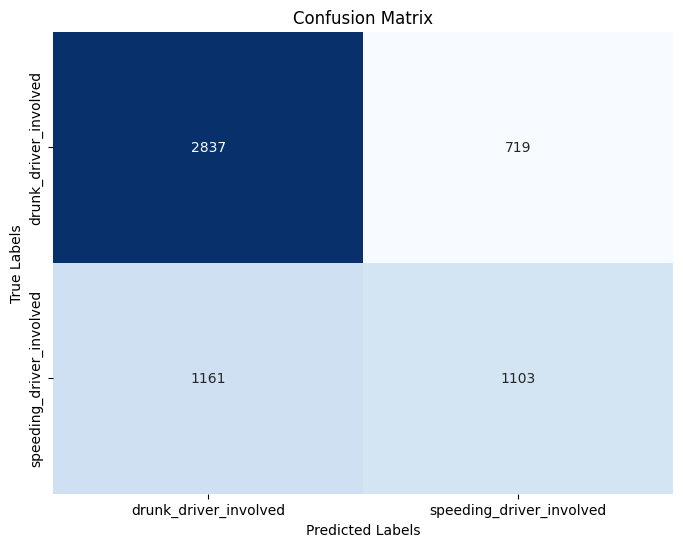

In [145]:
#Measure Output of MultiNomial Model
cat_lbl = ['drunk_driver_involved', 'speeding_driver_involved']
cm = confusion_matrix(y_test_dvs, predict_dvs, labels = cat_lbl )

print(f"f1 score: {f1_score(y_test_dvs, predict_dvs, average='macro', labels=cat_lbl)}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=cat_lbl,  yticklabels=cat_lbl)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [146]:
#Take X_Test data from first round prediction, filter out "OTHER", and do second round of prediction
X_test['Pred_1'] = predict
filtered_X_Test = X_test[X_test['Pred_1'] == 'Not Other']
dvs_test = filtered_X_Test.drop(columns='Pred_1')

In [155]:
X_test.shape

(13586, 82)

In [147]:
X_test.head()

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type,Pred_1
23710,1,2,20,1,1,0,1,0,0,0,...,False,False,False,True,False,False,False,5,0,Not Other
19637,1,1,16,1,9,0,1,0,1,1,...,True,False,False,False,False,False,False,4,0,Not Other
739,1,1,59,1,10,0,1,0,0,1,...,False,False,False,True,False,False,False,3,0,Other
20547,1,1,87,1,11,0,1,0,0,0,...,False,True,False,False,False,False,False,4,0,Not Other
26530,1,1,23,1,4,0,1,0,1,1,...,False,False,False,False,False,False,False,3,0,Not Other


In [148]:
filtered_X_Test.head()

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type,Pred_1
23710,1,2,20,1,1,0,1,0,0,0,...,False,False,False,True,False,False,False,5,0,Not Other
19637,1,1,16,1,9,0,1,0,1,1,...,True,False,False,False,False,False,False,4,0,Not Other
20547,1,1,87,1,11,0,1,0,0,0,...,False,True,False,False,False,False,False,4,0,Not Other
26530,1,1,23,1,4,0,1,0,1,1,...,False,False,False,False,False,False,False,3,0,Not Other
27581,1,2,27,1,7,0,1,0,1,1,...,False,True,False,False,False,False,False,2,0,Not Other


In [149]:
dvs_test.head()

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - lighted,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type
23710,1,2,20,1,1,0,1,0,0,0,...,False,False,False,False,True,False,False,False,5,0
19637,1,1,16,1,9,0,1,0,1,1,...,False,True,False,False,False,False,False,False,4,0
20547,1,1,87,1,11,0,1,0,0,0,...,False,False,True,False,False,False,False,False,4,0
26530,1,1,23,1,4,0,1,0,1,1,...,True,False,False,False,False,False,False,False,3,0
27581,1,2,27,1,7,0,1,0,1,1,...,False,False,True,False,False,False,False,False,2,0


In [150]:
# Put X_Test into model_DVS (i.e. Drunk vs. Speeding)
predict_2 = model_dvs.predict(dvs_test)
print(predict_2)

['speeding_driver_involved' 'drunk_driver_involved'
 'drunk_driver_involved' ... 'drunk_driver_involved'
 'speeding_driver_involved' 'drunk_driver_involved']


In [151]:
# Recombine with DVS_Test to get indexes for predictions
dvs_test['Predict_2'] = predict_2

In [152]:
dvs_test.head()

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type,Predict_2
23710,1,2,20,1,1,0,1,0,0,0,...,False,False,False,True,False,False,False,5,0,speeding_driver_involved
19637,1,1,16,1,9,0,1,0,1,1,...,True,False,False,False,False,False,False,4,0,drunk_driver_involved
20547,1,1,87,1,11,0,1,0,0,0,...,False,True,False,False,False,False,False,4,0,drunk_driver_involved
26530,1,1,23,1,4,0,1,0,1,1,...,False,False,False,False,False,False,False,3,0,drunk_driver_involved
27581,1,2,27,1,7,0,1,0,1,1,...,False,True,False,False,False,False,False,2,0,speeding_driver_involved


# TODO:  Take DVS_Test and assemble with Precition_1 output for X_Test and build new F score reuslts.

### Step 1: Multinomial to predict Other or Not-Other

### Step 2: Anything predict as Not-Other goes through another Prediction
- Step 2a: Create additional Model for not-other (i.e. Drunk vs. Speeding)
- Step 2b: Predict for not-Other (i.e. Drunk vs Speeding)
    
### Step 3: Combine results of Step 1 and Step 2 to recalculate FScore

In [257]:
# Take entire TEST Dataset and perform MultiNomialNB based on if it is OTHER or NOT-OTHER
X = cleaned_df
y_oVn = df['driver_factor'].apply(lambda x: 'Other' if x=='other' else 'Not Other')

In [286]:
X

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - lighted,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type
0,1,1,62,1,10,0,1,0,0,1,...,False,True,False,False,False,False,False,False,4,0
1,1,1,40,1,6,0,1,0,0,0,...,False,False,False,False,True,False,False,False,3,0
2,1,1,26,0,7,1,1,0,0,1,...,False,False,False,False,True,False,False,False,2,4
3,1,1,64,0,9,1,1,0,0,1,...,False,True,False,False,False,False,False,False,5,1
4,1,1,45,1,9,0,1,0,0,1,...,False,True,False,False,False,False,False,False,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45281,1,2,24,0,3,1,2,1,1,1,...,True,False,False,False,False,False,False,False,2,0
45282,1,1,18,1,5,0,1,0,0,1,...,False,True,False,False,False,False,False,False,6,0
45283,1,1,43,1,12,0,1,0,0,0,...,False,True,False,False,False,False,False,False,0,0
45284,1,1,21,1,5,0,1,0,1,1,...,True,False,False,False,False,False,False,False,6,0


In [287]:
df["driver_factor"]

0                           other
1        speeding_driver_involved
2                           other
3                           other
4           drunk_driver_involved
                   ...           
45281                       other
45282    speeding_driver_involved
45283                       other
45284                       other
45285       drunk_driver_involved
Name: driver_factor, Length: 45286, dtype: object

In [258]:
df["driver_factor"].unique()

array(['other', 'speeding_driver_involved', 'drunk_driver_involved'],
      dtype=object)

In [259]:
y_oVn.unique()

array(['Other', 'Not Other'], dtype=object)

In [260]:
# Shape of the whole dataset
X.shape

(45286, 81)

In [308]:
X_train, X_test, y_train, y_test = train_test_split(X, y_oVn, test_size=.30, random_state=500)

In [318]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y_oVn, test_size=.30, random_state=500)

# Scale numerical variables
scaler = StandardScaler()
numerical_cols = ["age", "ve_total"]
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])


# Train a GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

   Not Other       0.84      0.04      0.07      5849
       Other       0.58      0.99      0.73      7737

    accuracy                           0.58     13586
   macro avg       0.71      0.52      0.40     13586
weighted avg       0.69      0.58      0.45     13586



In [317]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y_oVn, test_size=.30, random_state=500)


# Train a RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Not Other       0.70      0.72      0.71      5849
       Other       0.79      0.77      0.78      7737

    accuracy                           0.75     13586
   macro avg       0.74      0.75      0.74     13586
weighted avg       0.75      0.75      0.75     13586



In [312]:
X_train

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - lighted,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type
17107,1,1,28,1,8,0,1,0,1,1,...,False,True,False,False,False,False,False,False,2,0
23550,1,1,27,1,7,0,1,0,0,1,...,False,True,False,False,False,False,False,False,4,0
18250,1,1,44,0,8,1,1,1,0,0,...,False,False,False,False,True,False,False,False,5,2
42090,1,2,34,1,10,0,1,0,0,1,...,False,True,False,False,False,False,False,False,3,0
42215,1,1,22,1,5,0,1,0,0,0,...,False,False,False,False,True,False,False,False,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19389,1,2,26,0,7,1,1,1,0,1,...,True,False,False,False,False,False,False,False,5,0
3790,1,1,46,1,1,0,2,0,0,0,...,False,False,False,False,True,False,False,False,4,0
41233,1,1,50,0,3,1,1,1,0,1,...,False,True,False,False,False,False,False,False,5,1
44865,1,1,21,1,7,0,1,0,0,1,...,False,True,False,False,False,False,False,False,4,0


In [262]:
# Shape of the training datset
X_train.shape

(31700, 81)

In [309]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

In [310]:
# Define the parameter grid to search
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'fit_prior': [True, False]
}

In [311]:
# Initialize the Multinomial Naive Bayes model
model = MultinomialNB()

# Increase the number of iterations
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
best_predictions = best_model.predict(X_test)
best_macro_f1 = f1_score(y_test, best_predictions, average='macro')

print(f"Best Parameters: {best_params}")
print(f"Best Macro F1 Score: {best_macro_f1}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'alpha': 10.0, 'fit_prior': True}
Best Macro F1 Score: 0.7184446191034208


In [263]:
# Multinomial Model
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [264]:
predict_1 = model.predict(X_test)
print(predict_1)

['Not Other' 'Not Other' 'Other' ... 'Other' 'Other' 'Other']


In [265]:
len(predict)

13586

f1 score: 0.7174201524593325


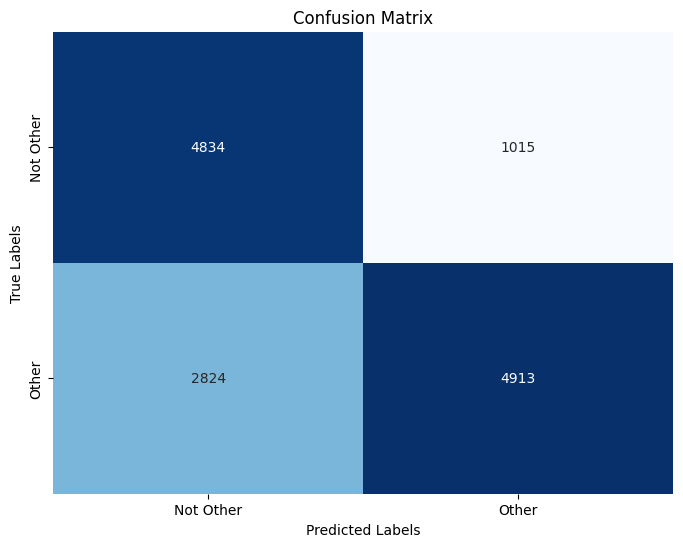

In [266]:
#Measure Output of MultiNomial Model
cat_lbl = ['Not Other', 'Other']
cm = confusion_matrix(y_test, predict, labels = cat_lbl )

print(f"f1 score: {f1_score(y_test, predict_1, average='macro', labels=cat_lbl)}")
#0.5503871319938812

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=cat_lbl,  yticklabels=cat_lbl)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [267]:
dvs_test = X_test
dvs_test['Prediction_1'] = predict

In [268]:
dvs_test

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type,Prediction_1
23710,1,2,20,1,1,0,1,0,0,0,...,False,False,False,True,False,False,False,5,0,Not Other
19637,1,1,16,1,9,0,1,0,1,1,...,True,False,False,False,False,False,False,4,0,Not Other
739,1,1,59,1,10,0,1,0,0,1,...,False,False,False,True,False,False,False,3,0,Other
20547,1,1,87,1,11,0,1,0,0,0,...,False,True,False,False,False,False,False,4,0,Not Other
26530,1,1,23,1,4,0,1,0,1,1,...,False,False,False,False,False,False,False,3,0,Not Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32650,1,1,23,1,7,0,1,0,0,1,...,False,False,False,False,False,False,False,3,0,Not Other
19709,1,6,21,0,7,1,1,1,1,0,...,False,False,False,True,False,False,False,3,4,Other
34565,1,1,48,1,9,0,1,0,0,1,...,False,False,False,False,False,False,False,2,4,Other
45137,1,1,65,0,4,1,1,1,0,0,...,False,False,False,True,False,False,False,3,3,Other


In [269]:
y_dVn = df['driver_factor'].apply(lambda x: 'Drunk_Driver' if x=='drunk_driver_involved' else 'Not_Drunk_Driver')

In [270]:
df["driver_factor"].unique()

array(['other', 'speeding_driver_involved', 'drunk_driver_involved'],
      dtype=object)

In [271]:
y_dVn.unique()

array(['Not_Drunk_Driver', 'Drunk_Driver'], dtype=object)

In [272]:
y_dVn.head()

0    Not_Drunk_Driver
1    Not_Drunk_Driver
2    Not_Drunk_Driver
3    Not_Drunk_Driver
4        Drunk_Driver
Name: driver_factor, dtype: object

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y_dVn, test_size=.30, random_state=500)

In [274]:
X_train.head()

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - lighted,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type
17107,1,1,28,1,8,0,1,0,1,1,...,False,True,False,False,False,False,False,False,2,0
23550,1,1,27,1,7,0,1,0,0,1,...,False,True,False,False,False,False,False,False,4,0
18250,1,1,44,0,8,1,1,1,0,0,...,False,False,False,False,True,False,False,False,5,2
42090,1,2,34,1,10,0,1,0,0,1,...,False,True,False,False,False,False,False,False,3,0
42215,1,1,22,1,5,0,1,0,0,0,...,False,False,False,False,True,False,False,False,4,0


In [275]:
y_dVn.head()

0    Not_Drunk_Driver
1    Not_Drunk_Driver
2    Not_Drunk_Driver
3    Not_Drunk_Driver
4        Drunk_Driver
Name: driver_factor, dtype: object

['Drunk_Driver' 'Drunk_Driver' 'Not_Drunk_Driver' ... 'Not_Drunk_Driver'
 'Not_Drunk_Driver' 'Not_Drunk_Driver']
f1 score: 0.6705929596711098


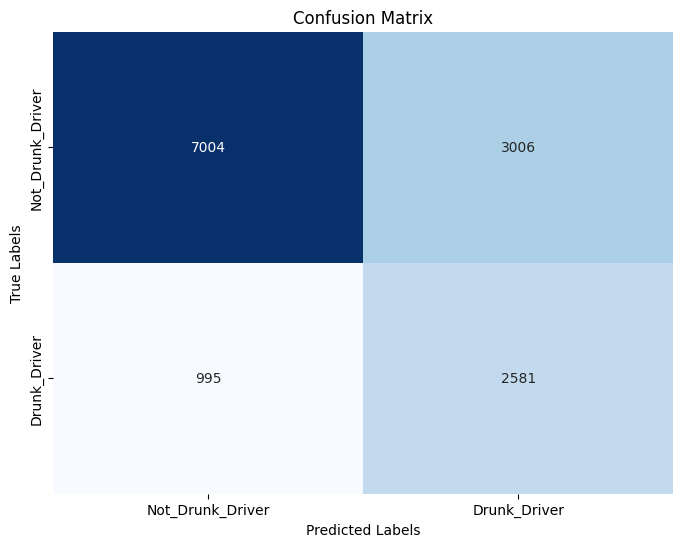

In [276]:
# Multinomial Model
model = MultinomialNB()
model.fit(X_train, y_train)

predict_2 = model.predict(X_test)
print(predict_2)

#Measure Output of MultiNomial Model
cat_lbl = ['Not_Drunk_Driver', 'Drunk_Driver']
cm = confusion_matrix(y_test, predict_2, labels = cat_lbl )

print(f"f1 score: {f1_score(y_test, predict_2, average='macro', labels=cat_lbl)}")
#0.5503871319938812

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=cat_lbl,  yticklabels=cat_lbl)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [277]:
dvs_test['Prediction_2'] = predict_2
dvs_test

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type,Prediction_1,Prediction_2
23710,1,2,20,1,1,0,1,0,0,0,...,False,False,True,False,False,False,5,0,Not Other,Drunk_Driver
19637,1,1,16,1,9,0,1,0,1,1,...,False,False,False,False,False,False,4,0,Not Other,Drunk_Driver
739,1,1,59,1,10,0,1,0,0,1,...,False,False,True,False,False,False,3,0,Other,Not_Drunk_Driver
20547,1,1,87,1,11,0,1,0,0,0,...,True,False,False,False,False,False,4,0,Not Other,Not_Drunk_Driver
26530,1,1,23,1,4,0,1,0,1,1,...,False,False,False,False,False,False,3,0,Not Other,Drunk_Driver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32650,1,1,23,1,7,0,1,0,0,1,...,False,False,False,False,False,False,3,0,Not Other,Drunk_Driver
19709,1,6,21,0,7,1,1,1,1,0,...,False,False,True,False,False,False,3,4,Other,Not_Drunk_Driver
34565,1,1,48,1,9,0,1,0,0,1,...,False,False,False,False,False,False,2,4,Other,Not_Drunk_Driver
45137,1,1,65,0,4,1,1,1,0,0,...,False,False,True,False,False,False,3,3,Other,Not_Drunk_Driver


In [278]:
df["driver_factor"].unique()

array(['other', 'speeding_driver_involved', 'drunk_driver_involved'],
      dtype=object)

In [279]:
y_sVn = df['driver_factor'].apply(lambda x: 'Speeding_Driver' if x=='speeding_driver_involved' else 'Not_Speeding_Driver')

In [280]:
y_sVn.unique()

array(['Not_Speeding_Driver', 'Speeding_Driver'], dtype=object)

In [281]:
y_sVn.head()

0    Not_Speeding_Driver
1        Speeding_Driver
2    Not_Speeding_Driver
3    Not_Speeding_Driver
4    Not_Speeding_Driver
Name: driver_factor, dtype: object

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y_sVn, test_size=.30, random_state=500)

['Not_Speeding_Driver' 'Speeding_Driver' 'Not_Speeding_Driver' ...
 'Not_Speeding_Driver' 'Not_Speeding_Driver' 'Not_Speeding_Driver']
f1 score: 0.6093621923278237


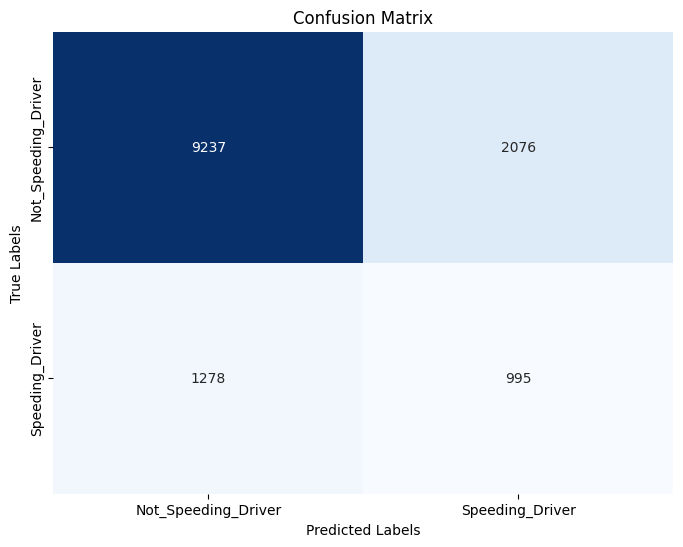

In [284]:
# Multinomial Model
model = MultinomialNB()
model.fit(X_train, y_train)

predict_3 = model.predict(X_test)
print(predict_3)

#Measure Output of MultiNomial Model
cat_lbl = ['Not_Speeding_Driver', 'Speeding_Driver']
cm = confusion_matrix(y_test, predict_3, labels = cat_lbl )

print(f"f1 score: {f1_score(y_test, predict_3, average='macro', labels=cat_lbl)}")
#0.5503871319938812

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=cat_lbl,  yticklabels=cat_lbl)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [285]:
dvs_test['Prediction_3'] = predict_3
dvs_test

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type,Prediction_1,Prediction_2,Prediction_3
23710,1,2,20,1,1,0,1,0,0,0,...,False,True,False,False,False,5,0,Not Other,Drunk_Driver,Not_Speeding_Driver
19637,1,1,16,1,9,0,1,0,1,1,...,False,False,False,False,False,4,0,Not Other,Drunk_Driver,Speeding_Driver
739,1,1,59,1,10,0,1,0,0,1,...,False,True,False,False,False,3,0,Other,Not_Drunk_Driver,Not_Speeding_Driver
20547,1,1,87,1,11,0,1,0,0,0,...,False,False,False,False,False,4,0,Not Other,Not_Drunk_Driver,Not_Speeding_Driver
26530,1,1,23,1,4,0,1,0,1,1,...,False,False,False,False,False,3,0,Not Other,Drunk_Driver,Not_Speeding_Driver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32650,1,1,23,1,7,0,1,0,0,1,...,False,False,False,False,False,3,0,Not Other,Drunk_Driver,Not_Speeding_Driver
19709,1,6,21,0,7,1,1,1,1,0,...,False,True,False,False,False,3,4,Other,Not_Drunk_Driver,Not_Speeding_Driver
34565,1,1,48,1,9,0,1,0,0,1,...,False,False,False,False,False,2,4,Other,Not_Drunk_Driver,Not_Speeding_Driver
45137,1,1,65,0,4,1,1,1,0,0,...,False,True,False,False,False,3,3,Other,Not_Drunk_Driver,Not_Speeding_Driver


In [ ]:
dvs_test["Prediction_Final"] = dvs_test.apply(lambda )